# NLU Final Project : Automated Descriptive Answer Grading System


## Aseem Mishra (G45760852) 
## Gianna Drego (G46986248) 
## Prima Sanghvi (G39952958) 
## Sagar Sheth (G32921700)

In [1]:
!pip install transformers torch datasets tqdm

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification
#from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
#from tqdm import tqdm
from tqdm.auto import tqdm
import pandas as pd
from typing import List, Dict, Any
import datasets
from datasets import load_metric
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

In [3]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("nkazi/SciEntsBank")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## **5 Way Grading**

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 4969
    })
    test_ua: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 540
    })
    test_uq: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 733
    })
    test_ud: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 4562
    })
})

In [5]:
df1 = pd.DataFrame(dataset['train'])
df1 = df1[['question', 'reference_answer', 'student_answer', 'label']]
df2 = pd.DataFrame(dataset['test_ud'])
df2 = df2[['question', 'reference_answer', 'student_answer', 'label']]
df= pd.concat([df1, df2], ignore_index=True)
df3 = pd.DataFrame(dataset['test_ua'])
df3 = df3[['question', 'reference_answer', 'student_answer', 'label']]
df4 = pd.DataFrame(dataset['test_uq'])
df4 = df4[['question', 'reference_answer', 'student_answer', 'label']]
df5= pd.concat([df3, df4], ignore_index=True)
df=pd.concat([df, df5], ignore_index=True)
df

,question,reference_answer,student_answer,label
0,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,3
1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0
2,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0
3,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,3
4,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,3
...,...,...,...,...
10799,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",Time is increasing while ice is decreasing.,0
10800,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",I think the ice cube is more like melting.,2
10801,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",The size of the ice cube decreasing and the ti...,0
10802,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...","Also, this one is decreasing.",3


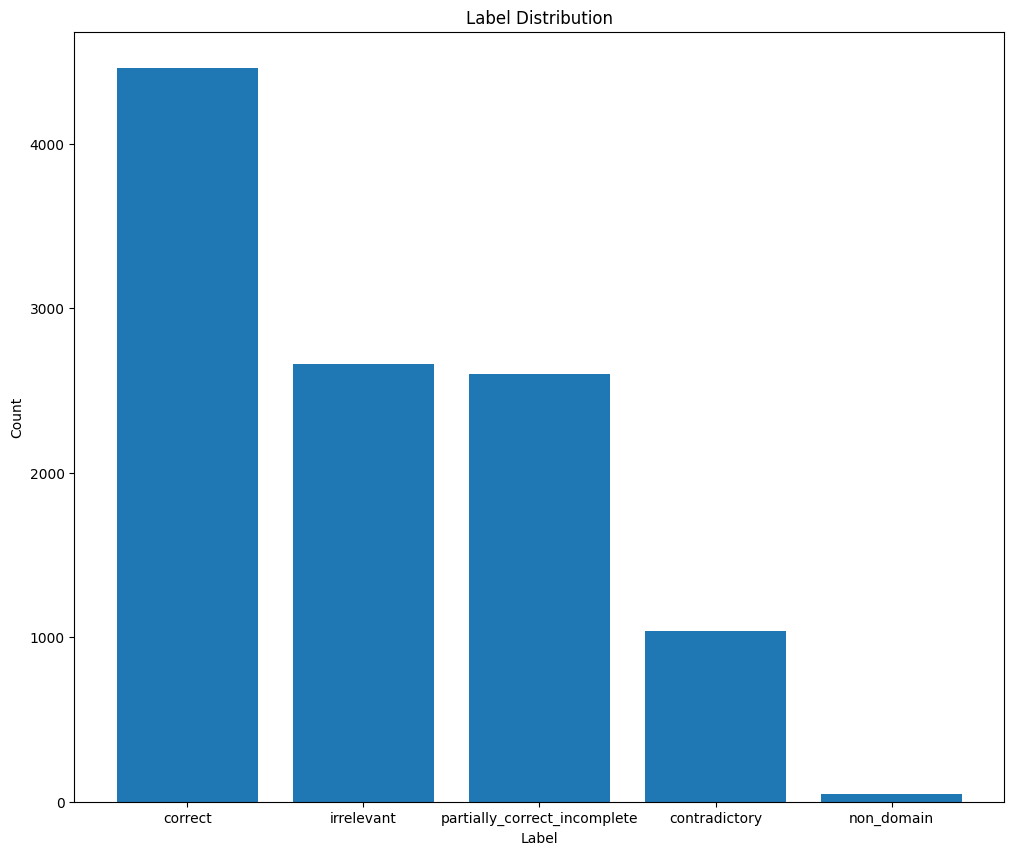

In [6]:
label_mapping = {
    0: 'correct',
    1: 'contradictory',
    2: 'partially_correct_incomplete',
    3: 'irrelevant',
    4: 'non_domain'
}
df['label_str'] = df['label'].map(label_mapping)


label_counts = df['label_str'].value_counts()
plt.figure(figsize=(12, 10))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [7]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)

In [9]:
test_df,valid_df= train_test_split(valid_df, test_size=0.67, random_state=42)

In [10]:
test_df

,question,reference_answer,student_answer,label,label_str,label_encoded
3325,Nathaniel and Sammy are trying to make up a co...,Sammy's. Different materials would make very d...,Sammy - Sammy it would be easier because plast...,2,partially_correct_incomplete,2
6478,During class Corey used the falling cup tool t...,The right hand is faster than the right foot b...,It takes less time to get a response to your h...,2,partially_correct_incomplete,2
9742,Denise made a circuit to light a bulb or run a...,The motor will run.,The bulb will still light.,3,irrelevant,3
414,The sand and flour in the gray material from m...,The sand particles are larger and settle first...,They separate because the water makes them int...,3,irrelevant,3
4870,3 girls wanted to see who could throw a ball t...,Different girls are throwing the balls. The gi...,The first variable they did not control is the...,0,correct,0
...,...,...,...,...,...,...
9392,"Joanna's glasses ""fogged up"" when she went int...",The glasses were cooler than the water vapor i...,Her glasses were a different temperature so th...,2,partially_correct_incomplete,2
7552,"Oil, water, and corn syrup are layered in a ta...",Corn syrup is denser than water.,That the corn syrup is less dense than the water.,1,contradictory,1
5331,Rachael tried to hatch brine shrimp under a ra...,Rachael could put the unhatched eggs in a salt...,If tested it for a long time.,3,irrelevant,3
10175,What is the evidence in this experiment that O...,The syringe for OJ1 rose higher because OJ1 pr...,There is more gas in the syringes.,0,correct,0


In [11]:
class QADataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset for question answering that can be iterated through using __getitem__
    """
    def __init__(self, df, tokenizer, max_length=150):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        student_answer = str(self.df.iloc[index]['student_answer'])
        reference_answer = str(self.df.iloc[index]['reference_answer'])
        label = self.df.iloc[index]['label_encoded']

        encoded_dict = self.tokenizer.encode_plus(
            student_answer,
            reference_answer,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # input_ids = encoded_dict['input_ids'].squeeze(0)
        # attention_mask = encoded_dict['attention_mask'].squeeze(0)

        return {
      'input_ids': encoded_dict['input_ids'][0],
      'attention_mask': encoded_dict['attention_mask'][0],
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [12]:


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = QADataset(train_df, tokenizer)
validation_dataset = QADataset(valid_df, tokenizer)
test_dataset = QADataset(test_df, tokenizer)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

batch_size = 100

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
device = torch.device("cuda")
#device = torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [14]:

for batch in validation_dataloader:
  print(batch)
  break

{'input_ids': tensor([[  101,  2002,  2003,  ...,     0,     0,     0],
        [  101,  1996,  7318,  ...,     0,     0,     0],
        [  101, 15241,  4589,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  3645,  ...,     0,     0,     0],
        [  101,  1996,  7077,  ...,     0,     0,     0],
        [  101,  2027,  2147,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([3, 3, 0, 0, 3, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 3, 1, 0, 2, 3,
        0, 3, 0, 0, 2, 0, 2, 3, 0, 2, 2, 3, 2, 1, 1, 1, 1, 2, 1, 3, 0, 2, 0, 3,
        0, 3, 0, 1, 2, 2, 3, 0, 2, 3, 0, 2, 3, 0, 3, 3, 2, 1, 0, 3, 0, 2, 0, 0,
        3, 2, 2, 0, 2, 0, 2, 0, 3, 0, 0, 1, 0, 0, 3, 2, 2, 3, 0, 1, 3, 3, 3, 0,
        0, 2, 2, 1])}


In [15]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay,classification_report,roc_curve, auc,multilabel_confusion_matrix


In [16]:
def update_metrics(metrics: List[datasets.Metric], predictions: torch.Tensor, labels: torch.Tensor) -> None:
  """
  Update a list of metrics with new predictions and labels

  Parameters:
  -----------
  metrics : List[Metric]
      List of metrics.
  predictions : torch.Tensor
      Tensor of predictions of shape (batch_size, ...)
  labels : torch.Tensor
      Tensor of labels of shape (batch_size, ...)

  Returns:
  --------
  None
  """
  # Nothing TODO here! This updates metrics based on a batch of predictions
  # and a batch of labels.
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

def evaluate(model: torch.nn.Module, validation_dataloader: torch.utils.data.DataLoader,
             device: torch.device, metric_strs: List[str]) -> Dict[str, float]:
  """
  Evaluate a PyTorch Model

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be evaluated.
  test_dataloader : torch.utils.data.DataLoader
      DataLoader containing testing examples.
  device : torch.device
      The device that the evaluation will be performed on.
  metric_strs : List[str]
      The names of Hugging Face metrics to use.

  Returns:
  --------
  Dict[str, float]
      Dictionary of metric names mapped to their values.
  """
  # load metrics
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
  model.eval()

  # we like progress bars :)
  progress_bar = tqdm(range(len(validation_dataloader)))
  # HINT: progress_bar.update(1) should be used to show progress after an iteration

  all_predictions = []
  all_labels = []
  # TODO: Fill in the evaluate function by applying the model with the dataloader
  for batch in validation_dataloader:

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        all_predictions.extend(predictions.detach().cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())
        update_metrics(metrics, predictions.detach(), batch['labels'])
        progress_bar.update(1)




  # HINT: Use .detach() before passing the predictions into update_metrics to prevent memory issues
  # and to send the model inputs to the device the model is on

  # compute and return metrics (nothing TODO here)
  computed = {}
  for m in metrics:
    computed = {**computed, **m.compute()}

  return computed,all_labels, all_predictions

In [17]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs: List[float], names: List[str]) -> None:
  """
  Create bar plots for performance metrics.

  Parameters:
  -----------
  perfs : List[float]
      List of performance values (e.g., accuracies).
  names : List[str]
      List of names for the corresponding performance metrics.
  """
  # Nothing TODO here
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

**Baseline Metrics**

<ipython-input-16-bf825858e5a0>:45: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Baseline accuracy: 0.293732460243218


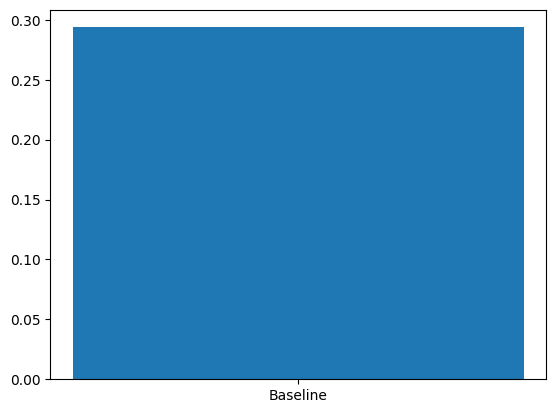

In [18]:
metrics = ['accuracy']
# TODO: evaluate on the test dataset
baseline_result,all_labels, all_predictions = evaluate(model,test_dataloader, device,metric_strs=metrics)
baseline_result =baseline_result['accuracy']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)

# now, plot! Do not modify the following:
results = [baseline_result]
names = ['Baseline']
make_plots(results, names)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

                         Correct       0.00      0.00      0.00       442
                   Contradictory       0.00      0.00      0.00        96
Partially correct but incomplete       0.27      0.84      0.41       261
                      Irrelevant       0.37      0.37      0.37       263
                      Non-domain       0.00      0.00      0.00         7

                        accuracy                           0.29      1069
                       macro avg       0.13      0.24      0.15      1069
                    weighted avg       0.16      0.29      0.19      1069



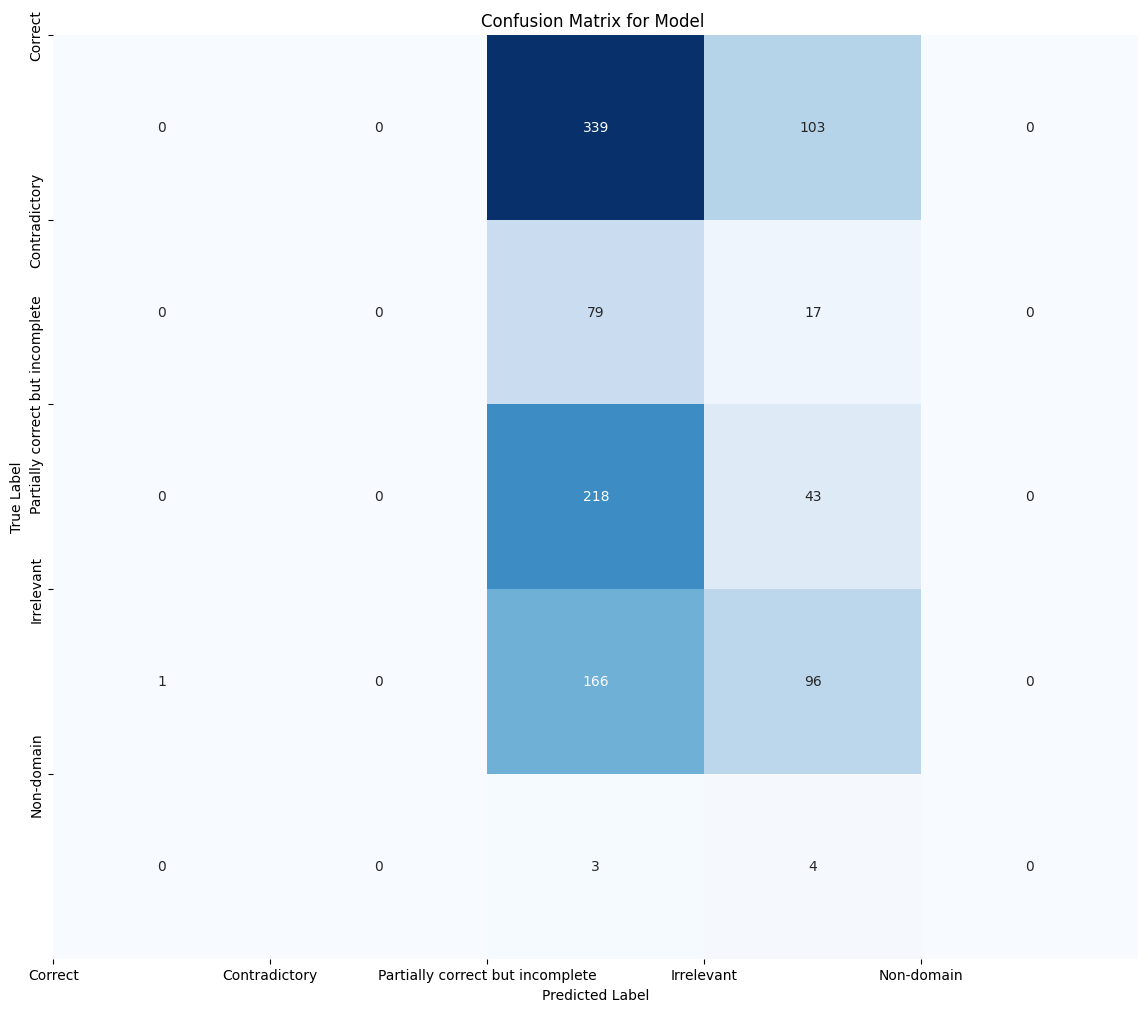

In [19]:
classlabel = ['Correct','Contradictory','Partially correct but incomplete','Irrelevant','Non-domain']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions,target_names=classlabel))
plt.figure(figsize=(14, 12))
sn.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.yticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.show()

In [20]:
from torch.optim import Optimizer

In [21]:
def train(model: torch.nn.Module, optimizer: Optimizer, num_epochs: int,
          train_dataloader: DataLoader, validation_dataloader: DataLoader,
          lr_scheduler: Any, device: torch.device) -> None:
  """
  Trains a model by performing a forward pass and backpropating on batches to optimize loss.

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  optimizer : torch.optim.Optimizer
      The training optimizer.
  num_epochs : int
      Number of epochs to train for.
  train_dataloader : DataLoader
      DataLoader containing training examples.
  validation_dataloader : DataLoader
      DataLoader containing validation examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.

  Returns:
  --------
  None
  """

  # Define your loss function; Use CrossEntropyLoss
  loss_function = torch.nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    # put the model in training mode (important that this is done each epoch,
    # since we put the model into eval mode during validation)
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    # TODO: Fill in the rest of the train function by applying the model with the dataloader
    # HINT: Remember to use .detach() before passing model predictions to update_metrics function,
    # and to send the model inputs .to() the device that the model is on
    for batch in train_dataloader:

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_function(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        predictions = torch.argmax(outputs.logits, dim=-1)
        update_metrics(metrics, predictions.detach(), batch['labels'])


    # print the epoch's average metrics
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")

    # normally, validation would be more useful when training for many epochs
    print("Running validation:")
    # TODO: evaluate model on validation dataset
    val_metrics,all_labels, all_predictions = evaluate(model, validation_dataloader, device, ['accuracy'])
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics['accuracy']}")


In [22]:
from transformers import get_scheduler

num_epochs = 10

# TODO: use the AdamW optimizer. Use torch.optim.AdamW.
# instantiate it on the untrained model parameters with a learning rate of 5e-5
optimizer =  torch.optim.AdamW(model.parameters(), lr=5e-5)

# now, we set up the learning rate scheduler
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [23]:
torch.cuda.empty_cache()
model.to(device)

# TODO: now call your training loop!
train(model,optimizer,num_epochs,train_dataloader,validation_dataloader,lr_scheduler,device)

Epoch 1 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.4508066649034647
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 1 validation: accuracy=0.5821445006902899
Epoch 2 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.6545887331393812
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 2 validation: accuracy=0.6543948458352508
Epoch 3 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3 average training metrics: accuracy=0.7642158159217138
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 3 validation: accuracy=0.6916705016106764
Epoch 4 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 4 average training metrics: accuracy=0.8368156572335361
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 4 validation: accuracy=0.7077772664519097
Epoch 5 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 5 average training metrics: accuracy=0.8927532398836286
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 5 validation: accuracy=0.7063966866083755
Epoch 6 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 6 average training metrics: accuracy=0.9336154456492991
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 6 validation: accuracy=0.7045559134836631
Epoch 7 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 7 average training metrics: accuracy=0.9627082782332717
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 7 validation: accuracy=0.7027151403589508
Epoch 8 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 8 average training metrics: accuracy=0.9755355725998414
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 8 validation: accuracy=0.7174413253566498
Epoch 9 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 9 average training metrics: accuracy=0.984792382967469
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 9 validation: accuracy=0.7142199723884032
Epoch 10 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 10 average training metrics: accuracy=0.9884951071145199
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 10 validation: accuracy=0.7100782328578003


**Trained Model Metrics**

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Baseline accuracy: 0.293732460243218
Trained accuracy: 0.7380729653882133


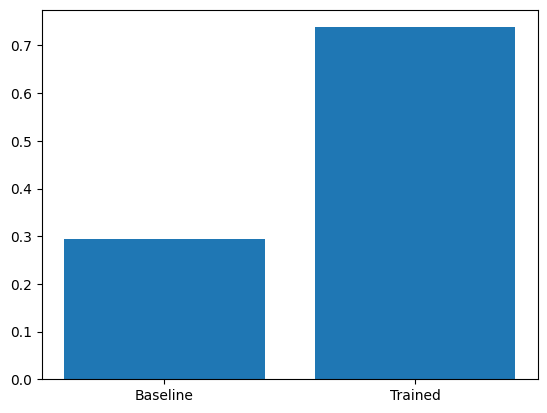

In [24]:
metrics = ['accuracy']

# TODO: Evaluate on test dataset!
trained_result,all_labels, all_predictions = evaluate(model,test_dataloader, device,metric_strs=['accuracy'])

# now, plot! Do not modify the following:
results = baseline_result, trained_result['accuracy']
names = ['Baseline', 'Trained']
make_plots(results, names)

                                  precision    recall  f1-score   support

                         Correct       0.79      0.81      0.80       442
                   Contradictory       0.62      0.57      0.59        96
Partially correct but incomplete       0.63      0.74      0.68       261
                      Irrelevant       0.83      0.67      0.74       263
                      Non-domain       0.67      0.57      0.62         7

                        accuracy                           0.74      1069
                       macro avg       0.71      0.67      0.69      1069
                    weighted avg       0.75      0.74      0.74      1069



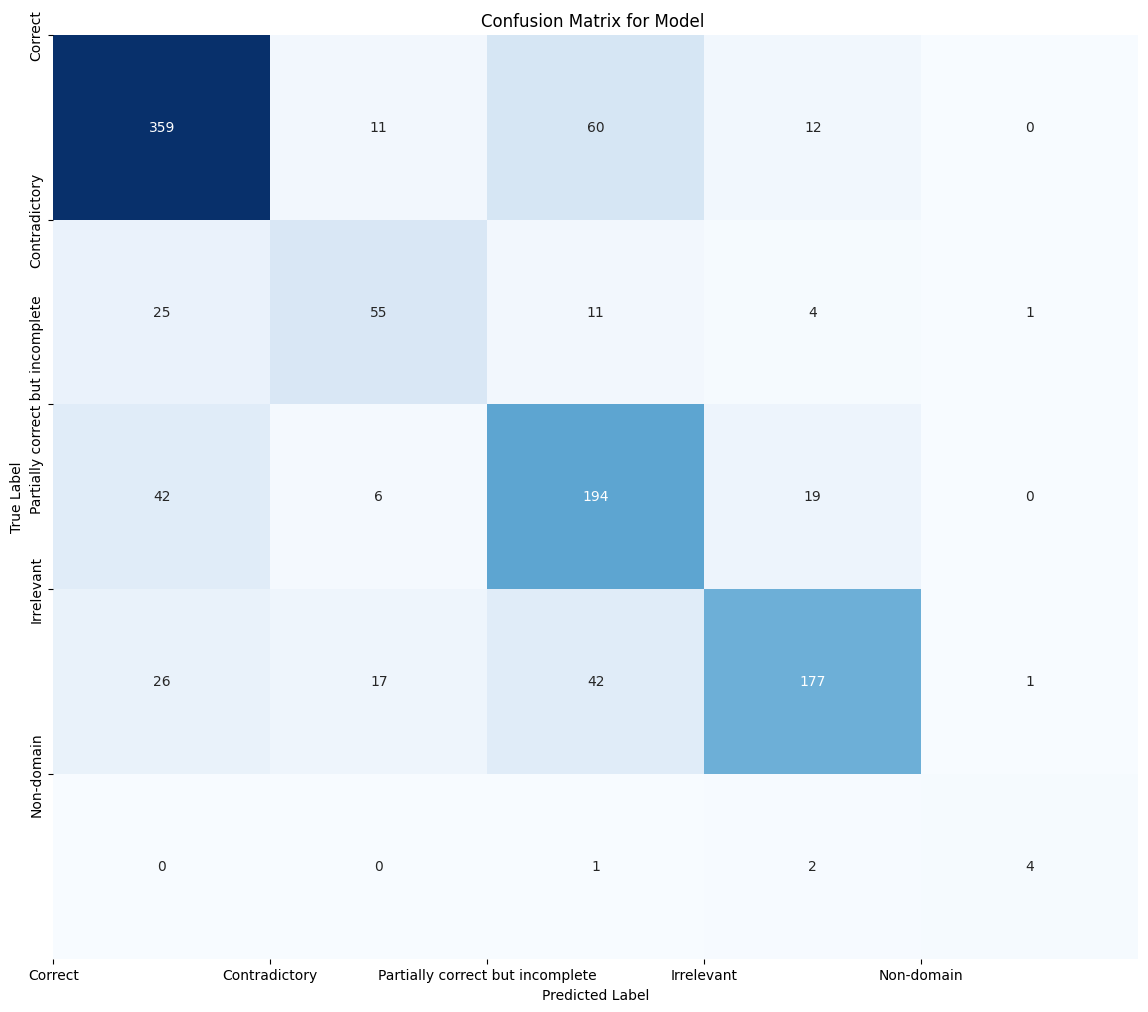

In [25]:
classlabel = ['Correct','Contradictory','Partially correct but incomplete','Irrelevant','Non-domain']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions,target_names=classlabel))
plt.figure(figsize=(14, 12))
sn.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.yticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.show()

In [ ]:
torch.cuda.empty_cache()

# **3 Way Grading**

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 4969
    })
    test_ua: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 540
    })
    test_uq: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 733
    })
    test_ud: Dataset({
        features: ['id', 'question', 'reference_answer', 'student_answer', 'label'],
        num_rows: 4562
    })
})

In [ ]:
from datasets import ClassLabel

dataset = dataset.align_labels_with_mapping({'correct': 0, 'contradictory': 1, 'partially_correct_incomplete': 2, 'irrelevant': 2, 'non_domain': 2}, 'label')
dataset = dataset.cast_column('label', ClassLabel(names=['correct', 'contradictory', 'incorrect']))



In [ ]:
df1 = pd.DataFrame(dataset['train'])
df1 = df1[['question', 'reference_answer', 'student_answer', 'label']]
df2 = pd.DataFrame(dataset['test_ud'])
df2 = df2[['question', 'reference_answer', 'student_answer', 'label']]
df= pd.concat([df1, df2], ignore_index=True)
df3 = pd.DataFrame(dataset['test_ua'])
df3 = df3[['question', 'reference_answer', 'student_answer', 'label']]
df4 = pd.DataFrame(dataset['test_uq'])
df4 = df4[['question', 'reference_answer', 'student_answer', 'label']]
df5= pd.concat([df3, df4], ignore_index=True)
df=pd.concat([df, df5], ignore_index=True)
df

,question,reference_answer,student_answer,label
0,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,2
1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0
2,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0
3,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,2
4,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,2
...,...,...,...,...
10799,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",Time is increasing while ice is decreasing.,0
10800,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",I think the ice cube is more like melting.,2
10801,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",The size of the ice cube decreasing and the ti...,0
10802,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...","Also, this one is decreasing.",2


In [ ]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
test_df,valid_df= train_test_split(valid_df, test_size=0.67, random_state=42)

In [ ]:
valid_df

,question,reference_answer,student_answer,label,label_encoded
6797,Describe how the muscles in the front and back...,The muscle in the back of the leg (the gastroc...,The tibia relaxes and the gastrocnemius contra...,0,0
8823,Johnny drove to the store with his father one ...,The windows were cooler than the water vapor i...,It was the coldest area possible for the conde...,2,2
5931,Look at the picture of a cow bone. What is the...,The rib bones form a cage to protect the inter...,That it does not move.,2,2
3669,Why was the siren's sound designed to have thi...,So that people notice the sound.,For the fire drill.,2,2
10086,You used 3 scratch tools in class to test mine...,"A paperclip is harder than a penny, so if a pe...",Because the penny is the middle hardness and t...,0,0
...,...,...,...,...,...
7801,Why does the level of the water in the straw g...,Water expands when water is heated.,Because the hotness causes it to go up.,2,2
1600,Look at the circuit in the picture. The gap be...,"No, string is an insulator, so the pathway wou...",No because you need to have a aluminum foil.,2,2
2249,Wendy is making an electromagnet. She wrapped ...,Wendy should hook one end of the wire to the n...,Wendy should connect the long wire to the batt...,2,2
6188,What is it about the human skeleton that allow...,The human skeleton can bend because the skelet...,Gliding joint hinge joint ball and socket join...,0,0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Assuming train_df and val_df are your DataFrames
train_dataset = QADataset(train_df, tokenizer)
validation_dataset = QADataset(valid_df, tokenizer)
test_dataset = QADataset(test_df, tokenizer)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

batch_size = 100

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda")
#device = torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**Baseline Metrics**

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Baseline accuracy: 0.2815715622076707


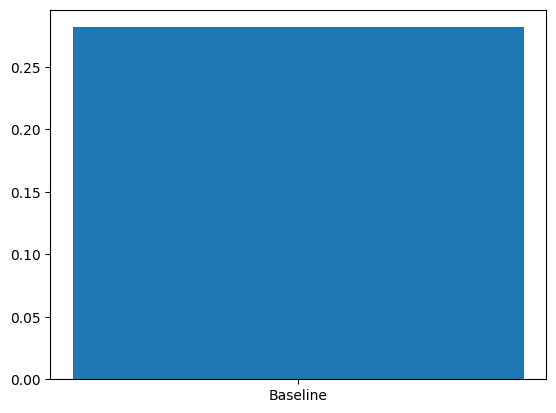

In [ ]:
metrics = ['accuracy']
# TODO: evaluate on the test dataset
baseline_result,all_labels, all_predictions = evaluate(model,test_dataloader, device,metric_strs=metrics)
baseline_result =baseline_result['accuracy']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)

# now, plot! Do not modify the following:
results = [baseline_result]
names = ['Baseline']
make_plots(results, names)

                   precision    recall  f1-score   support

          Correct       0.53      0.02      0.04       442
Partially correct       0.06      0.31      0.10        96
        Incorrect       0.46      0.49      0.48       531

         accuracy                           0.28      1069
        macro avg       0.35      0.28      0.21      1069
     weighted avg       0.45      0.28      0.26      1069



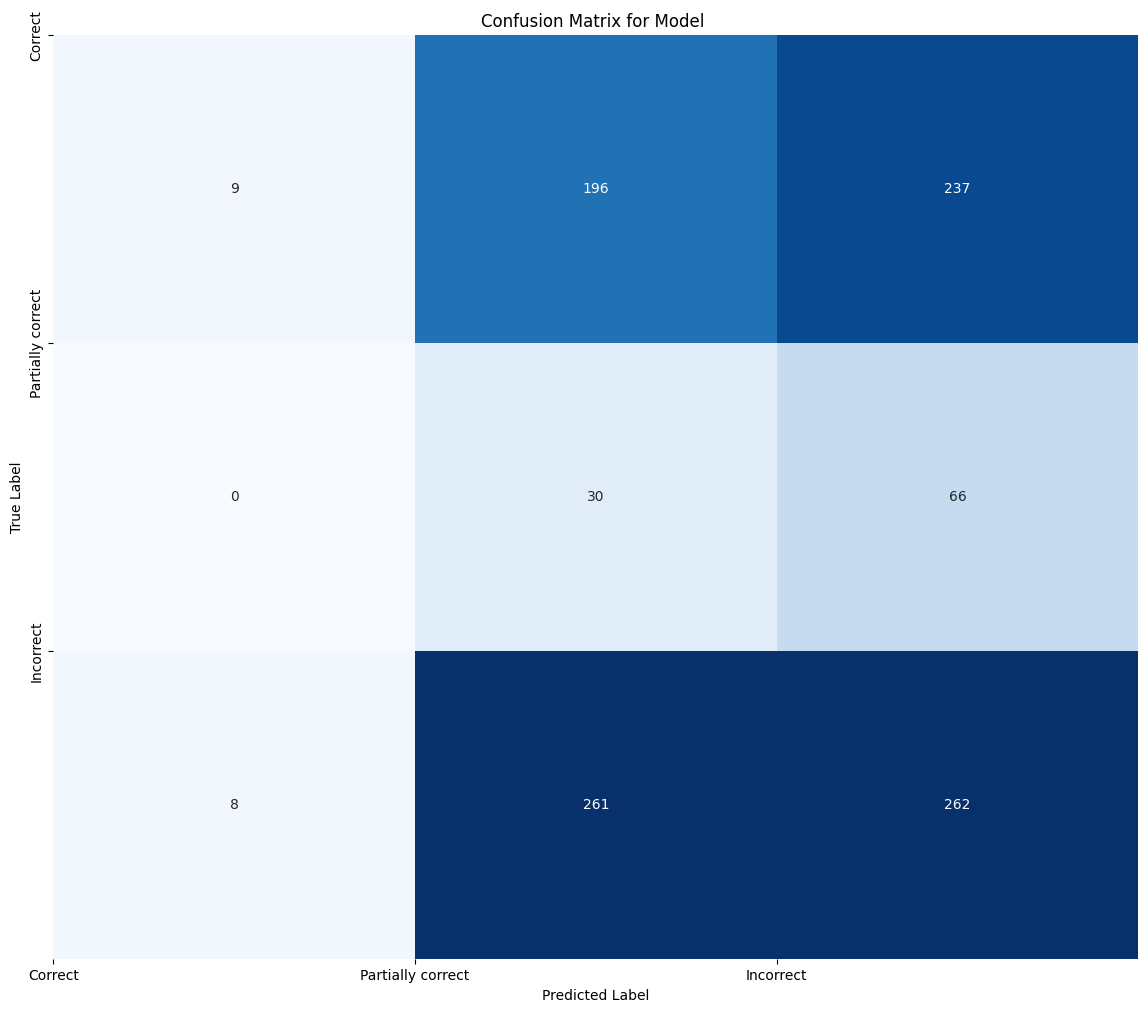

In [ ]:
classlabel = ['Correct','Partially correct','Incorrect']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions,target_names=classlabel))
plt.figure(figsize=(14, 12))
sn.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.yticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.show()

In [ ]:
from transformers import get_scheduler

num_epochs = 10

# TODO: use the AdamW optimizer. Use torch.optim.AdamW.
# instantiate it on the untrained model parameters with a learning rate of 5e-5
optimizer =  torch.optim.AdamW(model.parameters(), lr=5e-5)

# now, we set up the learning rate scheduler
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [ ]:
torch.cuda.empty_cache()
model.to(device)

# TODO: now call your training loop!
train(model,optimizer,num_epochs,train_dataloader,validation_dataloader,lr_scheduler,device)

Epoch 1 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.5806664903464692
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 1 validation: accuracy=0.6852277956741831
Epoch 2 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.7341973023009786
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 2 validation: accuracy=0.7386102162908421
Epoch 3 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3 average training metrics: accuracy=0.8115577889447236
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 3 validation: accuracy=0.7625402669121031
Epoch 4 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 4 average training metrics: accuracy=0.8660407299656175
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 4 validation: accuracy=0.7749654855039116
Epoch 5 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 5 average training metrics: accuracy=0.9169531869875694
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 5 validation: accuracy=0.7763460653474459
Epoch 6 training:


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 6 average training metrics: accuracy=0.9468394604601957
Running validation:


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 6 validation: accuracy=0.7768062586286241
Epoch 7 training:


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 7 average training metrics: accuracy=0.964956360751124
Running validation:


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 7 validation: accuracy=0.7786470317533364
Epoch 8 training:


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 8 average training metrics: accuracy=0.976857974080931
Running validation:


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 8 validation: accuracy=0.786010124252186
Epoch 9 training:


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 9 average training metrics: accuracy=0.9863792647447766
Running validation:


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 9 validation: accuracy=0.7892314772204326
Epoch 10 training:


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 10 average training metrics: accuracy=0.9888918275588469
Running validation:


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 10 validation: accuracy=0.7919926369075011


**Trained Model Metrics**

  0%|          | 0/11 [00:00<?, ?it/s]

Baseline accuracy: 0.2815715622076707
Trained accuracy: 0.813844714686623


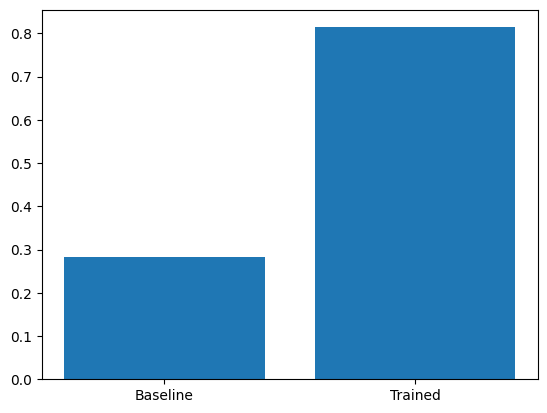

In [ ]:
metrics = ['accuracy']

# TODO: Evaluate on test dataset!
trained_result,all_labels, all_predictions = evaluate(model,test_dataloader, device,metric_strs=['accuracy'])

# now, plot! Do not modify the following:
results = baseline_result, trained_result['accuracy']
names = ['Baseline', 'Trained']
make_plots(results, names)

                   precision    recall  f1-score   support

          Correct       0.79      0.86      0.83       442
Partially correct       0.67      0.54      0.60        96
        Incorrect       0.85      0.82      0.84       531

         accuracy                           0.81      1069
        macro avg       0.77      0.74      0.75      1069
     weighted avg       0.81      0.81      0.81      1069



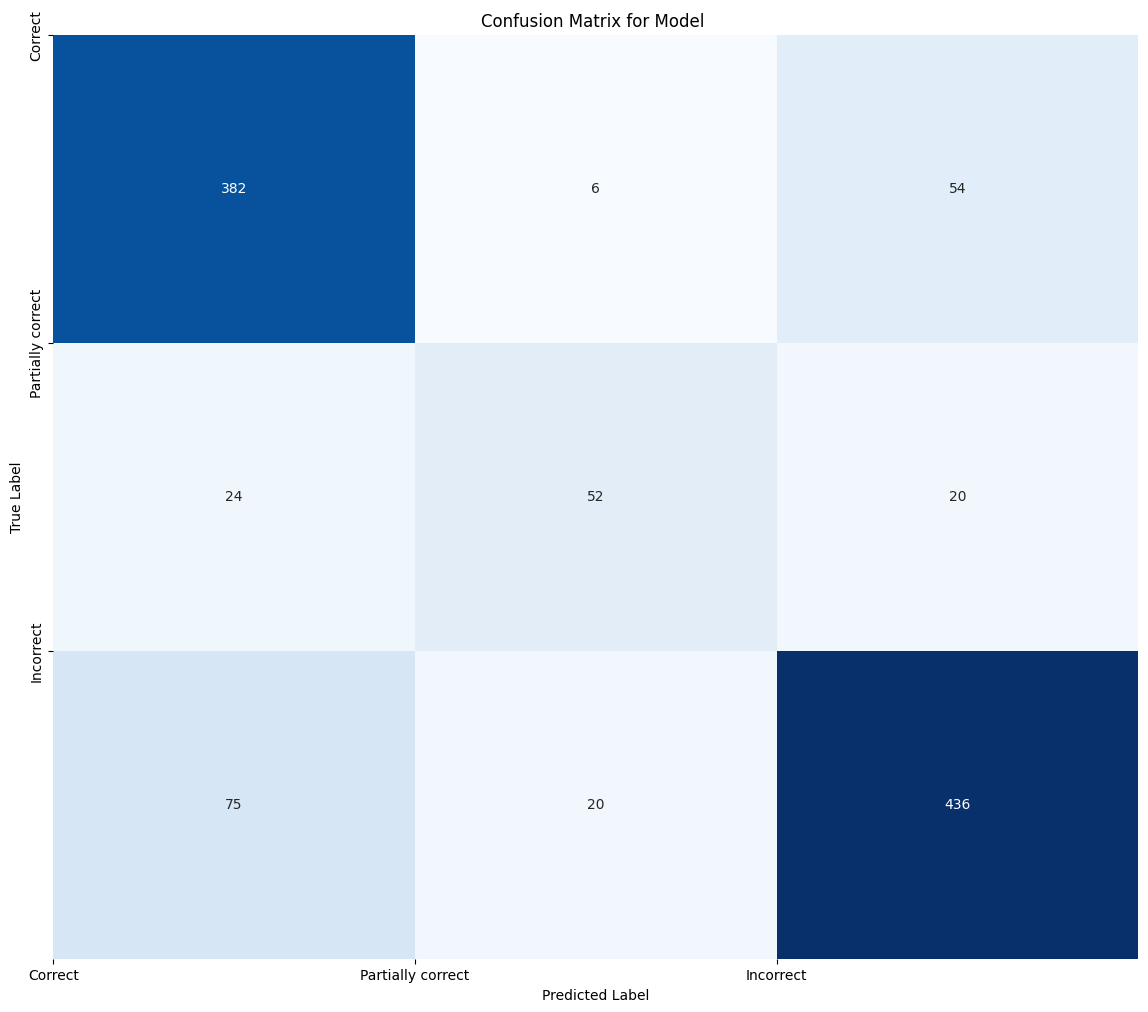

In [ ]:
classlabel = ['Correct','Partially correct','Incorrect']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions,target_names=classlabel))
plt.figure(figsize=(14, 12))
sn.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.yticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.show()

In [ ]:
torch.cuda.empty_cache()

# **2 Way Grading**

In [ ]:
from datasets import ClassLabel
dataset = dataset.align_labels_with_mapping({'correct': 0, 'contradictory': 1, 'partially_correct_incomplete': 1, 'irrelevant': 1, 'non_domain': 1}, 'label')
dataset = dataset.cast_column('label', ClassLabel(names=['correct', 'incorrect']))

In [ ]:
df1 = pd.DataFrame(dataset['train'])
df1 = df1[['question', 'reference_answer', 'student_answer', 'label']]
df2 = pd.DataFrame(dataset['test_ud'])
df2 = df2[['question', 'reference_answer', 'student_answer', 'label']]
df= pd.concat([df1, df2], ignore_index=True)
df3 = pd.DataFrame(dataset['test_ua'])
df3 = df3[['question', 'reference_answer', 'student_answer', 'label']]
df4 = pd.DataFrame(dataset['test_uq'])
df4 = df4[['question', 'reference_answer', 'student_answer', 'label']]
df5= pd.concat([df3, df4], ignore_index=True)
df=pd.concat([df, df5], ignore_index=True)
df

,question,reference_answer,student_answer,label
0,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,1
1,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,0
2,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,0
3,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,1
4,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,1
...,...,...,...,...
10799,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",Time is increasing while ice is decreasing.,0
10800,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",I think the ice cube is more like melting.,1
10801,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...",The size of the ice cube decreasing and the ti...,0
10802,Explain in one sentence what each graph tells ...,"As time increases, the size of the ice cube de...","Also, this one is decreasing.",1


In [ ]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
test_df,valid_df= train_test_split(valid_df, test_size=0.67, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Assuming train_df and val_df are your DataFrames
train_dataset = QADataset(train_df, tokenizer)
validation_dataset = QADataset(valid_df, tokenizer)
test_dataset = QADataset(test_df, tokenizer)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

batch_size = 100

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda")
#device = torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### **Baseline Model Metrics**

<ipython-input-6-bf825858e5a0>:45: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Baseline accuracy: 0.47333956969130025


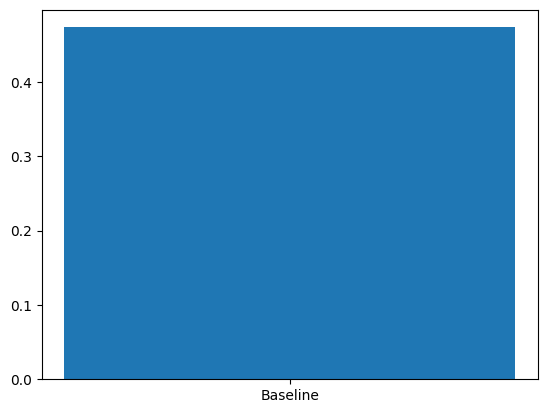

In [ ]:
metrics = ['accuracy']
# TODO: evaluate on the test dataset
baseline_result,all_labels, all_predictions = evaluate(model,test_dataloader, device,metric_strs=metrics)
baseline_result =baseline_result['accuracy']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)

# now, plot! Do not modify the following:
results = [baseline_result]
names = ['Baseline']
make_plots(results, names)

              precision    recall  f1-score   support

     Correct       0.35      0.33      0.34       442
   Incorrect       0.55      0.58      0.56       627

    accuracy                           0.47      1069
   macro avg       0.45      0.45      0.45      1069
weighted avg       0.47      0.47      0.47      1069



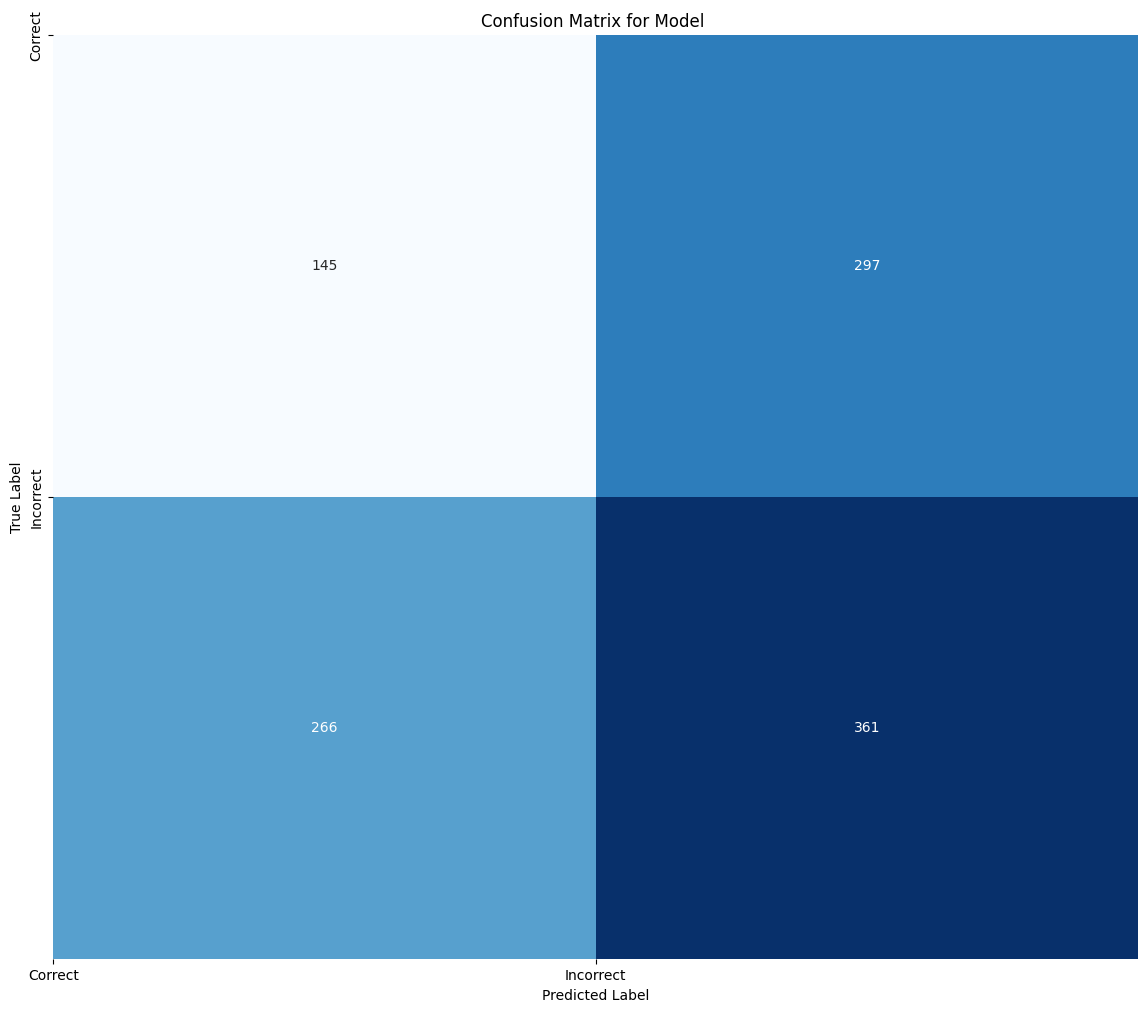

In [ ]:
classlabel = ['Correct','Incorrect']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions,target_names=classlabel))
plt.figure(figsize=(14, 12))
sn.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.yticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.show()

In [ ]:
from transformers import get_scheduler

num_epochs = 10

# TODO: use the AdamW optimizer. Use torch.optim.AdamW.
# instantiate it on the untrained model parameters with a learning rate of 5e-5
optimizer =  torch.optim.AdamW(model.parameters(), lr=5e-5)

# now, we set up the learning rate scheduler
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [ ]:
torch.cuda.empty_cache()
model.to(device)

# TODO: now call your training loop!
train(model,optimizer,num_epochs,train_dataloader,validation_dataloader,lr_scheduler,device)

Epoch 1 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.6519439301772018
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 1 validation: accuracy=0.7666820064427059
Epoch 2 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.7974080930970643
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 2 validation: accuracy=0.801196502531063
Epoch 3 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3 average training metrics: accuracy=0.8669664110023804
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 3 validation: accuracy=0.8131615278416935
Epoch 4 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 4 average training metrics: accuracy=0.9205236709865116
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 4 validation: accuracy=0.8260469397146801
Epoch 5 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 5 average training metrics: accuracy=0.9451203385347792
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 5 validation: accuracy=0.8214450069028992
Epoch 6 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 6 average training metrics: accuracy=0.9676011637133034
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 6 validation: accuracy=0.8246663598711459
Epoch 7 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 7 average training metrics: accuracy=0.9808251785241999
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 7 validation: accuracy=0.8177634606534745
Epoch 8 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 8 average training metrics: accuracy=0.9875694260777572
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 8 validation: accuracy=0.8306488725264611
Epoch 9 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 9 average training metrics: accuracy=0.9918011108172441
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 9 validation: accuracy=0.8283479061205706
Epoch 10 training:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 10 average training metrics: accuracy=0.9940491933350966
Running validation:


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 10 validation: accuracy=0.8320294523699954


### **Trained Model Metrics**

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Baseline accuracy: 0.47333956969130025
Trained accuracy: 0.842843779232928


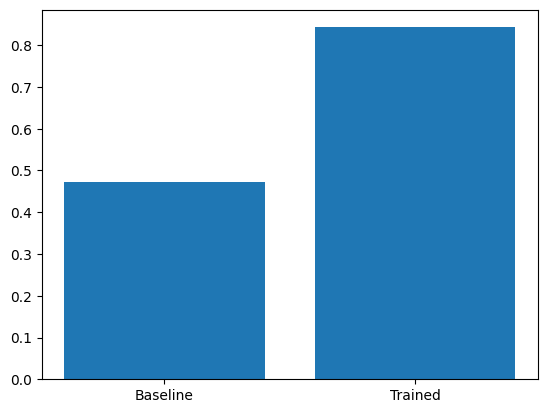

In [ ]:
metrics = ['accuracy']

# TODO: Evaluate on test dataset!
trained_result,all_labels, all_predictions = evaluate(model,test_dataloader, device,metric_strs=['accuracy'])

# now, plot! Do not modify the following:
results = baseline_result, trained_result['accuracy']
names = ['Baseline', 'Trained']
make_plots(results, names)

              precision    recall  f1-score   support

     Correct       0.80      0.83      0.81       442
   Incorrect       0.88      0.85      0.86       627

    accuracy                           0.84      1069
   macro avg       0.84      0.84      0.84      1069
weighted avg       0.84      0.84      0.84      1069



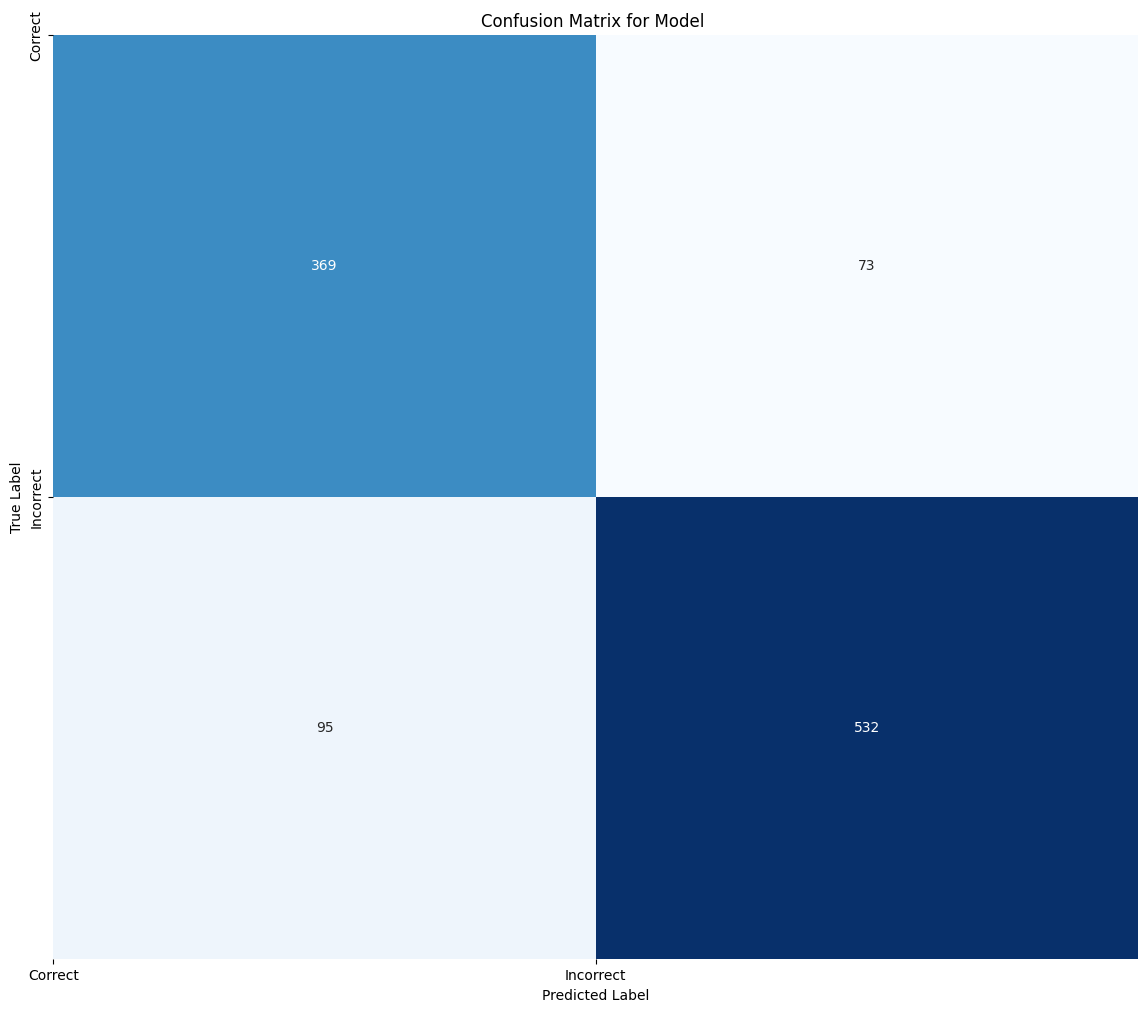

In [ ]:
classlabel = ['Correct','Incorrect']
confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions,target_names=classlabel))
plt.figure(figsize=(14, 12))
sn.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model ")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.yticks(ticks=np.arange(len(classlabel)), labels=classlabel)
plt.show()